In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import datamapplot
from llama_cpp import Llama
import sentence_transformers
pn.extension()

2024-05-16 01:51:26.900624: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 01:51:26.902998: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 01:51:26.934816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 01:51:26.934842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 01:51:26.934863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Let's load a dataframe containing our documents or objects to embed along with their metadata along with some high dimensional vectors representing these objects and a data_map or two dimensional numpy array of the vectors often constructed via umap.

In [2]:
data = pd.read_feather('all_arxiv_papers_umap_df.feather')
data_map = np.array(list(zip(data.x, data.y)))
data_vectors = np.load('all_arxiv_papers_all_mpnet-base-v2.npy')

In [3]:
import sys
topic_path=Path("/work/home/jchealy/STAMP2024/TopicNaming/")
sys.path.append(str(topic_path))
from topic_naming import Toponymy

In [4]:
llm = Llama(model_path=str(topic_path / "openhermes-2.5-mistral-7b.Q4_K_M.gguf"), n_gpu_layers=0, n_ctx=4096, stop=["--", "\n"], verbose=False, n_threads=48)
embedding_model = sentence_transformers.SentenceTransformer("all-mpnet-base-v2", device="cpu")

We instantiate a Toponymy object with our required information, embedding model and large language model.

We could simple call topic_namer.clean_topic_names() in order to get our topic names right away but instead we suggest calling fit_clusters() first.  
This will allow you to choose an appropriate resolution for your clustering before you go through the computational work of prompt generation and calling
an expensive large language model.

In [5]:
index = data.categories.str.contains('physics')
topic_namer = Toponymy(documents=data.title[index],
                       document_vectors=data_vectors[index,:], 
                       document_map=data_map[index,:], 
                       embedding_model=embedding_model,  
                       llm = llm,
                       document_type='titles',
                       corpus_description='physics articles',
                       verbose=True,
                      )
topic_namer.fit_clusters(base_min_cluster_size=500)

constructing cluster layers
cluster=24, last_min_cluster_size=500, min_cluster_size=1538
cluster=5, last_min_cluster_size=1538, min_cluster_size=4224


We can call a number of intermediary functions to examine or alter prompt along the way to getting our topic names but for now we will just call the final function to generate our prompts and final topic names.

In [6]:
topic_namer.clean_topic_names()

generating base layer topic names with at most 100 titles per cluster.
sampling documents per cluster


Batches:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

fitting intermediate layers


/work/home/jchealy/.local/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(
/work/home/jchealy/.local/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:269: RuntimeWarning: invalid value encountered in power
  self.supervised_weights_ = np.power(
/work/home/jchealy/.local/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(


  0%|          | 0/5 [00:00<?, ?it/s]

cleaning up topic names

Working on layer 1
Start on cluster 0 out of 5
Physics Informed Neural Networks And Machine Learning --> Astrophysics And Planetary Science With Artificial Intelligence after 1 attempts
Working on layer 0
Start on cluster 0 out of 24
Physics Informed Machine Learning And Climate Science --> Physics Informed Neural Networks In Scientific Simulations And Machine Learning Applications after 1 attempts
Physics Informed Neural Networks And Machine Learning --> Dark Matter Searches And Detection Experiments Using Advanced Techniques In Particle Physics after 1 attempts


The topics are now stored into the layer_clusters property.  This is a list of lists.  Each list is a layer from our layered clustering and each layer contains a single title for each document.  

In [7]:
pd.Series(topic_namer.layer_clusters[0]).value_counts()

Unlabelled                                                                                      25803
Cold Atomics And Frequency Combs                                                                 3253
Solar Wind And Magnetic Reconnection                                                             2848
Quantum Photonics                                                                                1777
Quantum Mechanics, Topology                                                                      1666
Lasers And Resonators                                                                            1552
Physics Informed Neural Networks In Scientific Simulations And Machine Learning Applications     1529
Advanced Optics And Quantum Photonics                                                            1481
Quantum Physics                                                                                  1474
Solar Physics And Plasma Turbulence                                               

These are perfectly suited for passing to the datamapplot library.  Let's throw the base layer of topics into a static datamapplot.  

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

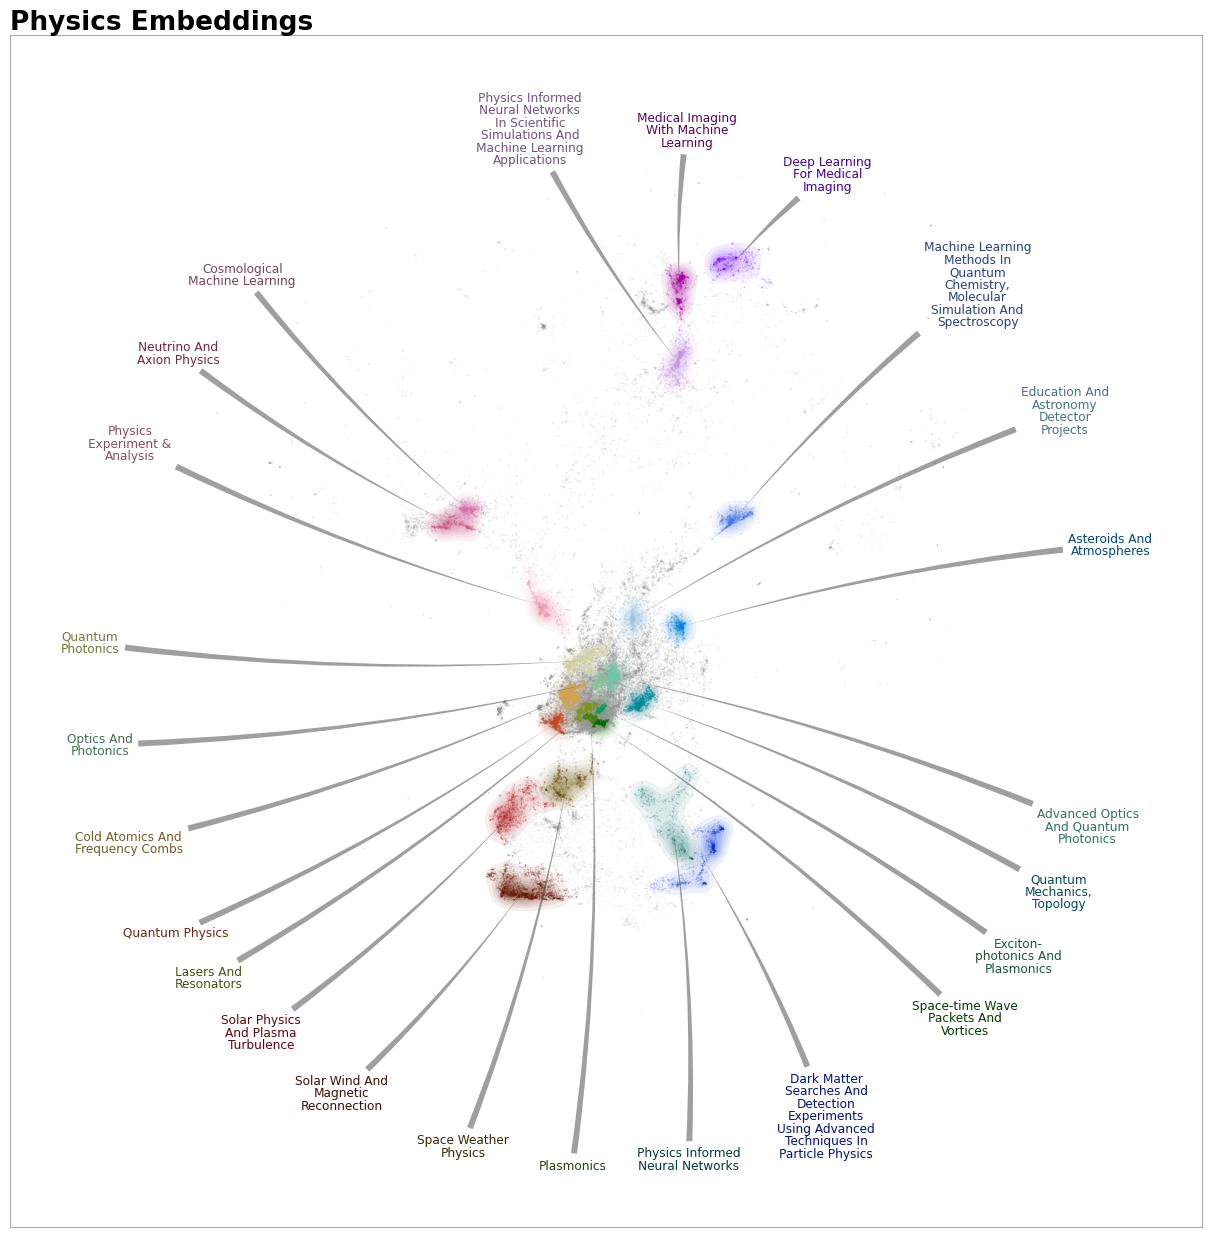

In [8]:
datamapplot.create_plot(
    data_map[index,:],
    labels=topic_namer.layer_clusters[0],
    title='Physics Embeddings',
    use_medoids=False,
    arrowprops={"arrowstyle":"wedge,tail_width=0.5", "connectionstyle":"arc3,rad=0.05", "linewidth":0, "fc":"#33333377"},
)
#plt.savefig(f"physics_topics.png", bbox_inches="tight");